<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Unsupervised%20Learning/Clustering/HierarchicalRiskParity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Paridad de riesgo jerárquica**

En este proyecto, aplicaremos la paridad de riesgo jerárquica basada en métodos de clustering y lo compararemos con otros métodos de asignación de carteras. El proyecto se basa en el documento _"Building Diversified Portfolios that Outperform Out-ofSample" (2016) de Marcos López de Prado._ 



## Contenido

* [1. Definición del problema](#0)
* [2. Inicio - Cargar bibliotecas y conjunto de datos](#1)
    * [2.1. Cargar Bibliotecas](#1.1)    
    * [2.2. Cargar el conjunto de datos](#1.2)
* [3. Análisis exploratorio de datos](#2)
    * [3.1. Estadísticas descriptivas](#2.1)    
    * [3.2. Visualización de datos](#2.2)
* [4. Preparación de los datos](#3)
    * [4.1. Limpieza de datos](#3.1)
    * [4.3.Transformación de datos](#3.2)  
* [5.Evaluar algoritmos y modelos](#4)        
    * [5.1. Construir gráfico de jerarquía/dendograma](#4.1)
    * [5.2. Pasos para la paridad de riesgo jerárquica](#4.2)
* [6.Backtesting-Out Of Sample](#5)  

<a id='0'></a>
# 1. Definición del problema

Nuestro objetivo en este proyecto es maximizar los rendimientos ajustados al riesgo utilizando un algoritmo basado en la reducción de la agrupación en un conjunto de datos de acciones para asignar el capital en diferentes clases de activos. 

<a id='1'></a>
# 2. Primeros pasos - Cargar los datos y los paquetes de Python

<a id='1.1'></a>
## 2.1. Carga de los paquetes python

Comprobando si los paquetes adicionales necesarios están presentes, si no los instala. Comprobemos si el paquete cvxopt está presente, si no lo instalamos.

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

In [2]:
# Carga de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

# Importar paquetes de modelos 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

# Paquete de optimización de la varianza media
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
## 2.2. Cargar los datos

In [3]:
# load dataset
dataset = read_csv('/content/SP500Data.csv',index_col=0)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Análisis exploratorio de datos

<a id='2.1'></a>
## 3.1. Estadísticas descriptivas

In [6]:
# shape
dataset.shape

(1057, 504)

In [7]:
# consultar los datos
set_option('display.width', 100)
dataset.head(5)

,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,61.529999,58.790001,98.410004,192.490005,153.839996,64.309998,40.090000,177.699997,115.989998,106.089996,...,31.139999,146.990005,164.300003,47.810001,68.070000,81.599998,103.709999,120.446602,50.700001,71.769997
2018-01-03,61.900002,58.919998,99.949997,195.820007,154.550003,65.309998,39.779999,181.039993,117.250000,107.050003,...,32.000000,149.740005,162.520004,47.490002,68.900002,81.529999,105.769997,121.281555,50.639999,72.099998
2018-01-04,62.189999,58.820000,99.379997,199.250000,156.380005,64.660004,40.450001,183.220001,118.370003,111.000000,...,32.549999,151.259995,163.399994,47.119999,69.360001,82.360001,107.860001,121.106796,50.849998,72.529999
2018-01-05,62.990002,58.990002,101.110001,202.320007,157.669998,66.370003,40.180000,185.339996,118.300003,112.180000,...,32.459999,152.229996,164.490005,46.790001,69.230003,82.839996,109.540001,122.310677,50.869999,73.360001
2018-01-08,63.290001,58.820000,99.489998,207.800003,158.929993,66.629997,40.090000,185.039993,117.940002,111.389999,...,32.580002,151.410004,162.300003,47.139999,69.480003,82.980003,110.629997,122.543686,50.619999,74.239998


<a id='2.2'></a>
## 3.2. Visualización de datos

Veremos la visualización de los datos en las secciones posteriores.

<a id='3'></a>
## 4. Preparación de datos

<a id='3.1'></a>
## 4.1. Limpieza de datos
Comprobamos los NA en las filas, los eliminamos o los rellenamos con la media de la columna.

In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1057, 504)

Eliminación de las columnas con más de un 30% de valores perdidos. 

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1057, 497)

Dado que hay valores nulos, se elimina la raíz que contiene los valores nulos.

In [10]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,61.529999,58.790001,98.410004,192.490005,153.839996,64.309998,40.090000,177.699997,115.989998,106.089996,...,31.139999,146.990005,164.300003,47.810001,68.070000,81.599998,103.709999,120.446602,50.700001,71.769997
2018-01-03,61.900002,58.919998,99.949997,195.820007,154.550003,65.309998,39.779999,181.039993,117.250000,107.050003,...,32.000000,149.740005,162.520004,47.490002,68.900002,81.529999,105.769997,121.281555,50.639999,72.099998
2018-01-04,62.189999,58.820000,99.379997,199.250000,156.380005,64.660004,40.450001,183.220001,118.370003,111.000000,...,32.549999,151.259995,163.399994,47.119999,69.360001,82.360001,107.860001,121.106796,50.849998,72.529999
2018-01-05,62.990002,58.990002,101.110001,202.320007,157.669998,66.370003,40.180000,185.339996,118.300003,112.180000,...,32.459999,152.229996,164.490005,46.790001,69.230003,82.839996,109.540001,122.310677,50.869999,73.360001
2018-01-08,63.290001,58.820000,99.489998,207.800003,158.929993,66.629997,40.090000,185.039993,117.940002,111.389999,...,32.580002,151.410004,162.300003,47.139999,69.480003,82.980003,110.629997,122.543686,50.619999,74.239998


<a id='3.2'></a>
## 4.2. Transformación de datos

A efectos de agrupación, utilizaremos los rendimientos
anuales. Además, entrenaremos los datos y luego los probaremos. Preparemos el conjunto de datos para el entrenamiento y la prueba, separando el 20% del conjunto de datos para la prueba y generando las series de rendimiento.

In [11]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [12]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [13]:
# Calcular el porcentaje de retorno 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

Los parámetros a agrupar son los índices y las variables utilizadas en la agrupación son las columnas. Por lo tanto, los datos están en el formato correcto para ser alimentados a los algoritmos de clustering

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

<a id='4.1'></a>
## 5.1. Construir un gráfico jerárquico / dendograma

El primer paso consiste en buscar grupos de correlaciones utilizando la técnica de clustering jerárquico aglomerado. La clase jerárquica tiene un método de dendrograma que toma el valor devuelto por el método de vinculación de
la misma clase.

Linkage hace la agrupación real en una línea de código, y devuelve una lista de los clusters unidos en el formato: $Z=[stock_1, stock_2, distance, sample_count]$

#### Calcular la correlación

In [14]:
def correlDist(corr):
    # Una matriz de distancia basada en la correlación, donde 0<=d[i,j]<=1
    # Esta es una métrica de distancia adecuada
    dist = ((1 - corr) / 2.)**.5  # matriz de distancia
    return dist

In [15]:
# Calcular el enlace
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([23.        , 24.        ,  0.08581646,  2.        ])

El cálculo de los vínculos va seguido de
la visualización de los clusters mediante un dendrograma, que muestra un árbol de clusters.
Las hojas son las poblaciones individuales y la raíz es el clúster único final. La "distancia" entre cada conglomerado se muestra en el eje y, por tanto, cuanto más largas sean las ramas, menos correlacionados estarán dos conglomerados.

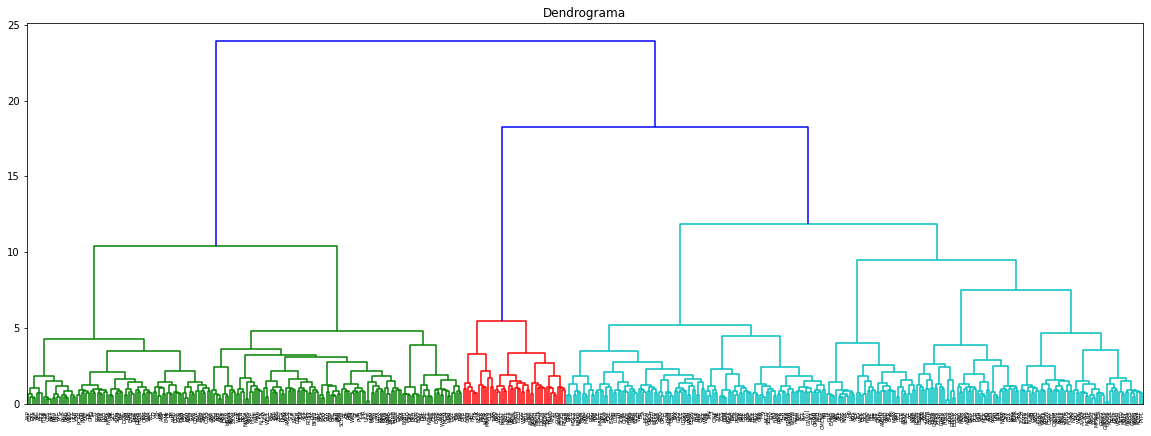

In [16]:
# Trazar Dendograma
plt.figure(figsize=(20, 7))
plt.title("Dendrograma")
dendrogram(link,labels = X.columns)
plt.show()

<a id='4.2'></a>
## 5.2 Pasos para la paridad jerárquica de riesgos

#### Cuasi-diagonalización y obtención de los pesos para la Paridad de Riesgo Jerárquica


La "cuasi-diagonalización" es un proceso que suele conocerse como seriación de la matriz y que puede realizarse mediante la agrupación jerárquica.
Este proceso reorganiza la matriz de covarianza para que las inversiones similares se coloquen juntas. Esta diagonalización de la matriz nos permite distribuir los pesos de forma óptima siguiendo una asignación de la varianza inversa.

In [17]:
def getQuasiDiag(link):
    # Ordenar los elementos agrupados por distancia
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # número de artículos originales
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # hacer espacio
        df0 = sortIx[sortIx >= numItems]  # encontrar agrupaciones
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # punto 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # punto 2
        sortIx = sortIx.sort_index()  # volver a clasificar
        sortIx.index = range(sortIx.shape[0])  # reindexar
    return sortIx.tolist()

#### Bisección recursiva

Este paso distribuye la asignación mediante una bisección recursiva basada en la covarianza de los clusters.

In [18]:
def getClusterVar(cov,cItems):
    # Calcular la varianza por clúster
    cov_=cov.loc[cItems,cItems] # corte de la matriz
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Calcular la asignación de HRP
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # inicializar todos los elementos de un clúster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-sección
        for i in range(0, len(cItems), 2):  # parsear en pares
            cItems0 = cItems[i]  # grupo 1
            cItems1 = cItems[i + 1]  # grupo 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # peso 1
            w[cItems1] *= 1 - alpha  # peso 2
    return w

#### Comparación con otros métodos de asignación de activos:


La premisa principal de este estudio de caso era desarrollar una alternativa a la asignación de activos basada en la cartera de varianza mínima de Markowitz. Así, en este paso, definimos unas funciones para comparar el rendimiento de los siguientes métodos de asignación de activos.

  1. __MVP__ - Cartera de Varianza Mínima de Markowitz
  2. __HRP__ - Paridad de riesgo jerárquico

In [19]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convertir a matrices cvxopt
    S = opt.matrix(cov)
    # pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Crear matrices de restricciones
    G = -opt.matrix(np.eye(n))  # matriz de identidad negativa n x n
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calcular los pesos de la frontera eficiente mediante programación cuadrática
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULAR LOS RIESGOS Y RENDIMIENTOS DE LA FRONTERA    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULAR EL POLINOMIO DE 2º GRADO DE LA CURVA FRONTERA
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULAR LA CARTERA ÓPTIMA    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Calcule la cartera de varianza inversa
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construir una cartera jerárquica
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    # plt.figure(figsize=(20, 10))
    # dn = sch.dendrogram(link, labels=cov.index.values)
    # plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Step 4:  Getting the portfolio weights for all types of asset allocation

In [20]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [21]:
portfolios = get_all_portfolios(returns)

Text(0.5, 1.0, 'HRP')

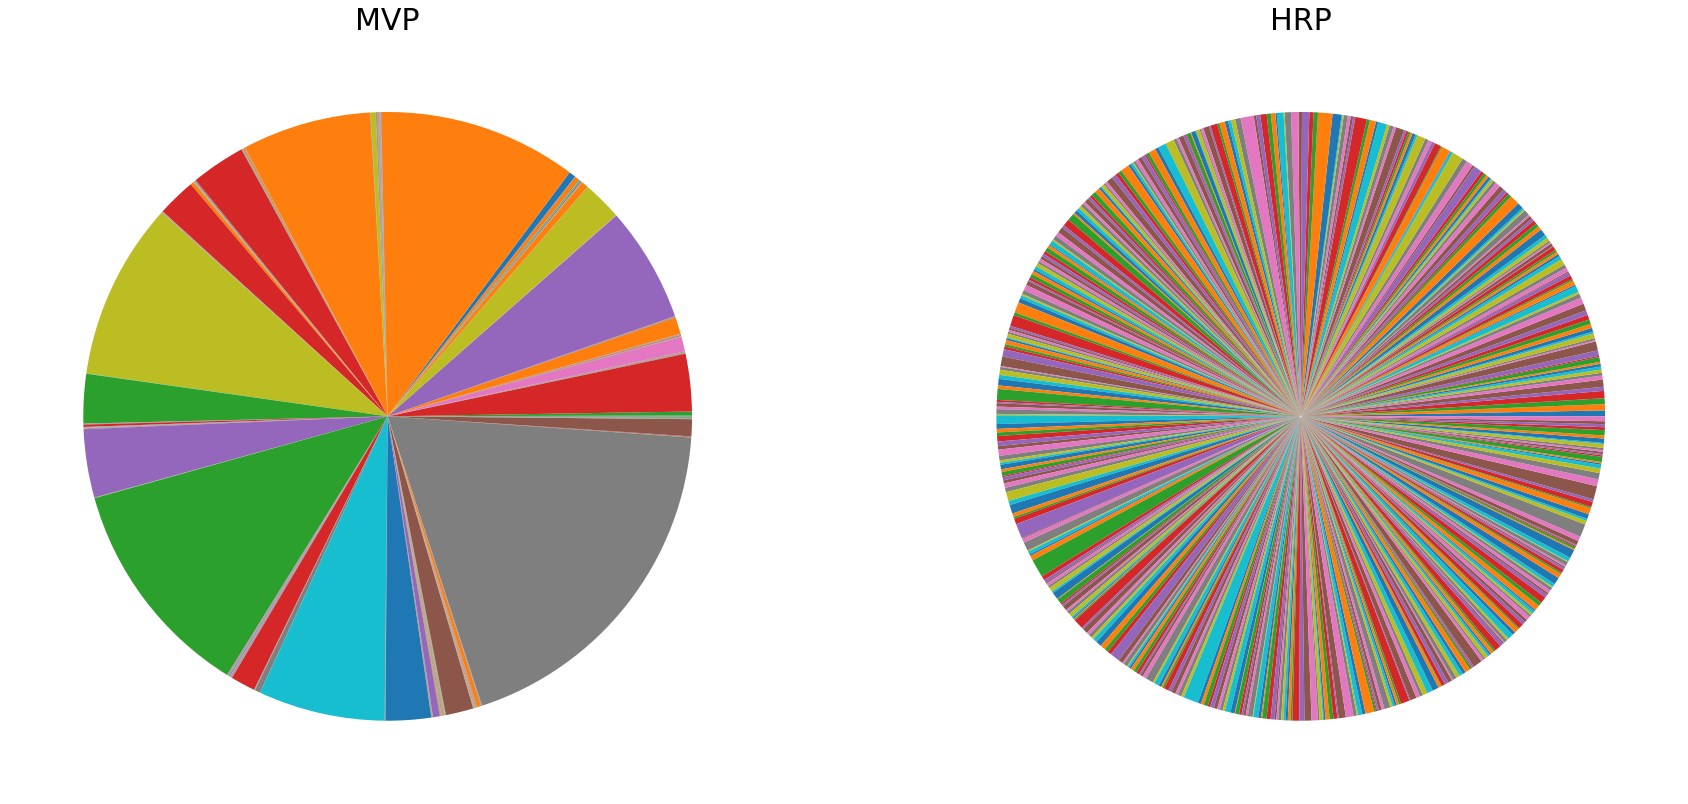

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

El primer gráfico circular muestra la asignación de activos de MVP, seguido de IVP y HRP. Vemos claramente una mayor diversificación en el HRP en comparación con el MVP. Por otro lado, el IVP distribuye uniformemente las ponderaciones entre todos los activos, y se parece al HRP. Sin embargo, este método ignora la estructura de correlación entre los instrumentos, a diferencia del HRP, que se incluye sólo a efectos de comparación. Veamos los resultados del backtesting.

<a id='5'></a>
# 6. Pruebas de backtesting fuera de la muestra

In [23]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

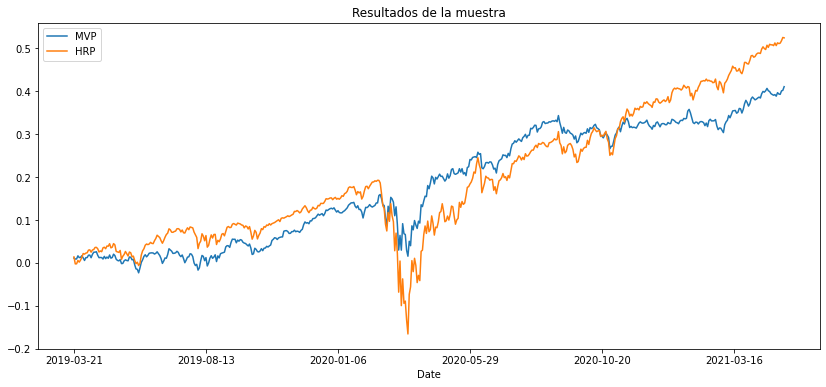

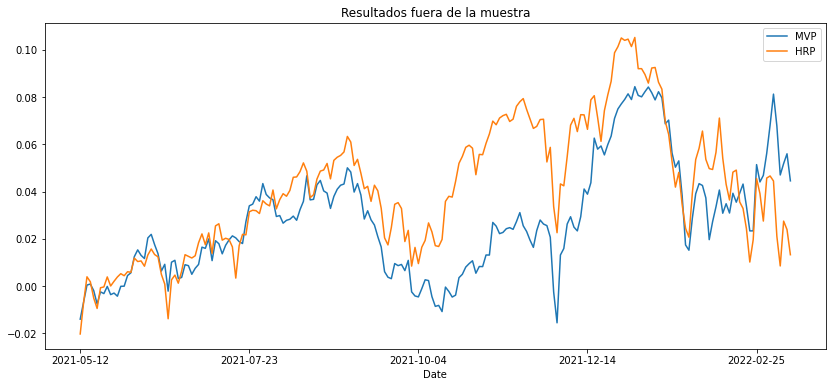

In [24]:
Insample_Result.cumsum().plot(figsize=(14, 6), title ="Resultados de la muestra")
OutOfSample_Result.cumsum().plot(figsize=(14, 6), title ="Resultados fuera de la muestra")

### Resultados en la muestra y fuera de la muestra

In [25]:
# Resultados de la muestra
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.155170,1.237363
HRP,0.234091,1.047525


In [26]:
# Resultados fuera de la muestra
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.110557,0.481124
HRP,0.127848,0.124251


Aunque el resultado dentro de la muestra del MVP parece prometedor, el ratio agudo fuera de la muestra y la rentabilidad global de la cartera construida mediante el enfoque de agrupación jerárquica son mejores. La diversificación que consigue HRP entre activos no correlacionados hace que la metodología sea más robusta frente a las perturbaciones

**Conclusión**

La asignación de cartera basada en la varianza mínima de Markowitz es menos diversa y está concentrada en unos pocos valores. En la asignación basada en la agrupación jerárquica, la asignación es más diversa y se distribuye entre muchos activos. Estas carteras ofrecen entonces una mejor gestión del riesgo de cola.

Por último, examinamos el marco de backtesting, que nos permite calcular y
analizar la rentabilidad dentro y fuera de la muestra y el ratio de sharpe de cada cartera hipotética. Esto ayuda a determinar cuál es el mejor rendimiento de todos los métodos de asignación de carteras. Los enfoques de agrupación jerárquica obtuvieron los mejores resultados fuera de muestra.
